# Maximum Likelihood Estimation
## Problem:
    Write a short Python (or Matlab, Julia etc.) script that 
    (1) generates some data y as the output of a parametric function of x (e.g. a polynomial), 
    (2) adds noise to it and plots y vs. x, then 
    (3) solves the inverse problem of identifying the parameters of the underlying function from data, using maximum likelihood estimation, and plots the fitted curve on the same plot as the data. 

In [1]:
using  Distributions, Plots, BenchmarkTools, SPGBox, ForwardDiff

Now, initialise variables:

In [2]:
nvar, n = 2, 201;

In [3]:
A = 1.; # Noise Amplitude

In [4]:
β = [0.5,1.6,7,3.2]; # Polynomial coeffs.

In [5]:
β̂ = zeros(4); # Initial MLE coeffs.

In [6]:
X = rand(Normal(0,1), n, nvar-1); # Normal distribution of samples

Create function to generate polynominal data with corresponding noise,

In [7]:
function gen(n, A, β, X)
    ϵ = randn(n) * A
    return (β[1] .+ X * β[2] .+ X.^2 * β[3] .+ X.^3 * β[4]) .+ ϵ
end;

Create the initial dataset for MLE and plot,

In [8]:
y = gen(n,A,β,X);

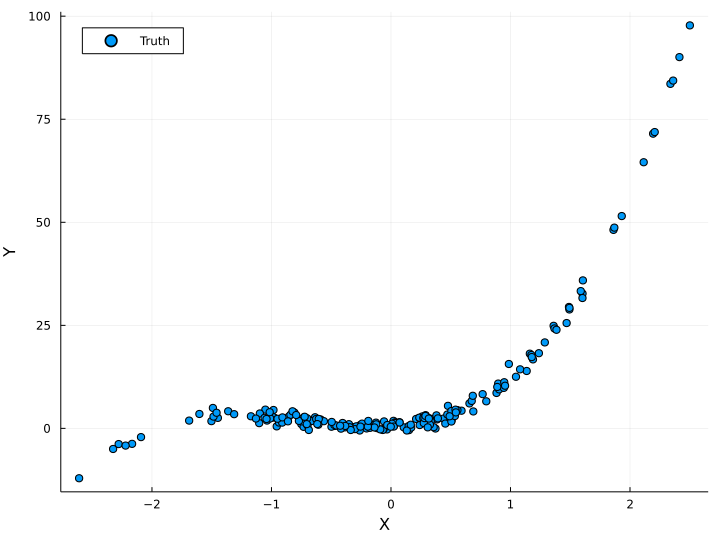

In [9]:
scatter(X, y, ylabel = "Y", xlabel = "X", label="Truth", legend=:topleft, size=(720,540))

Construct the negative loglikelihood function for minimisation,

In [10]:
function log_lkhd(n, A, β, X, y) 
    ŷ = gen(n,A,β,X)
    return -sum(logpdf.(Normal(0,1),y-ŷ))/n
end;

Construct the optimisation function to minimise the negative loglikelihood, utilising a spectral projected gradient method with mutation,

In [11]:
function Coeffs!(β̂, n, A, X, y, nvar)
    spgbox!(β -> log_lkhd(n, A, β, X, y),(g,β) -> ForwardDiff.gradient!(g,β -> log_lkhd(n, A, β, X, y),β), β̂, nitmax = 100)
end;

Run the MLE with the generated data while benchmarking the optimisation function,

In [12]:
@benchmark Coeffs!(β̂,n,A,X,y,nvar)

BenchmarkTools.Trial: 1281 samples with 1 evaluation.
 Range (min … max):  2.277 ms … 13.161 ms  ┊ GC (min … max):  0.00% … 60.33%
 Time  (median):     3.164 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   3.884 ms ±  1.593 ms  ┊ GC (mean ± σ):  18.51% ± 20.47%

     ▂█▇▅▂                                                    
  ▂▃██████▆▅▄▄▄▃▄▄▂▃▃▃▂▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▂▁▁▂▂▁ ▂
  2.28 ms        Histogram: frequency by time        9.17 ms <

 Memory estimate: 8.78 MiB, allocs estimate: 3161.

Assess the difference between the estimated coefficents and the ground truth,

In [13]:
μ =  β-β̂

4-element Vector{Float64}:
 -0.030191901609720406
  0.04856664422852597
  0.04065418047910807
  0.026068945424218448

Generate the data needed to plot the predicted function, sort it, then plot overtop of the previous,

In [14]:
ŷ = gen(n,0.,β̂,X);
ψ = sortslices([X[:] ŷ[:]], dims=1);

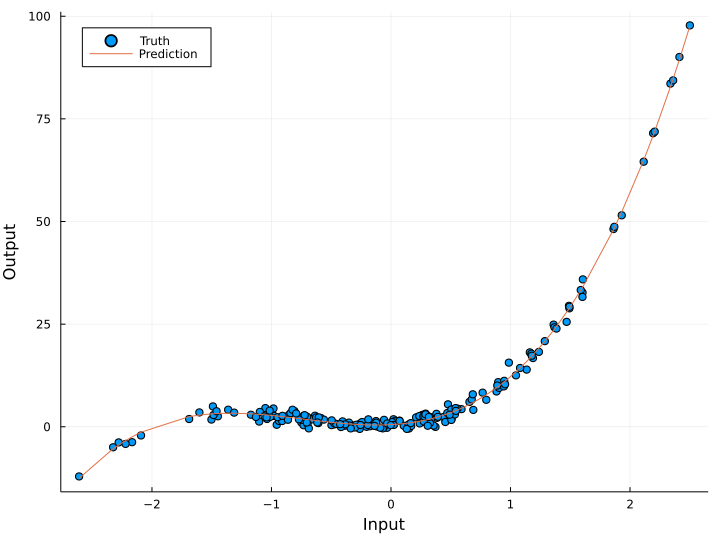

In [15]:
plot!(ψ[:,1], ψ[:,2], ylabel = "Output", xlabel = "Input", label="Prediction", legend=:topleft, size=(720,540))